In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.api import qqplot
from statsmodels.formula.api import ols #for linear regression
import seaborn as sns #for heatmap
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.tree import  DecisionTreeClassifier
from statsmodels.discrete.discrete_model import Logit
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

<h3> LOGISTIC REGRESSION </H2>
<p1>Using statsmodels to better interpret features that are important for employee churn</p1>

In [183]:
data=pd.read_csv("Employee_attrition (3).csv")

In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

In [185]:
data.Attrition=data.Attrition.apply(lambda x:1 if x=="Yes" else 0 )

In [186]:
#no missing values
data.isna().any().any()

False

In [187]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life_Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research_and_Development,8,1,Life_Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research_and_Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research_and_Development,3,4,Life_Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research_and_Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


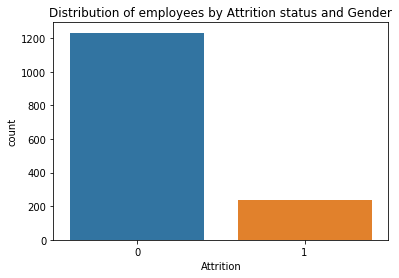

In [188]:
sns.countplot(x="Attrition",data=data)
plt.title("Distribution of employees by Attrition status and Gender")
plt.show()

In [189]:
#let's see percenatage of customers who didn't subscribe to term deposit,
#and percenatage of customers who subscribed to term deposit
data.Attrition.value_counts()/len(data)*100

0    83.877551
1    16.122449
Name: Attrition, dtype: float64

#### <p1>as we see our benchmark is about 84 percent our model should predict more precisely</p1>

In [190]:
df_num=data.select_dtypes(exclude="object")## we divide data in this groups to check, 
df_object=data.select_dtypes(include="object")#if there is exict a column containing only one value

In [191]:
df_num.any().var()==0 #se we have one more columns that  variance is equal to 0 meaning they represent the same number
#should be dropped in each observation se we do not need them.

True

In [192]:
for i in df_num:
    if df_num[i].var()==0:
        del df_num[i]

In [193]:
df_num.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,0.161224,802.485714,9.192517,2.912925,1024.865306,2.721769,65.891156,2.729932,2.063946,...,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,0.367863,403.509100,8.106864,1.024165,602.024335,1.093082,20.329428,0.711561,1.106940,...,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,0.000000,102.000000,1.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,465.000000,2.000000,2.000000,491.250000,2.000000,48.000000,2.000000,1.000000,...,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.000000,802.000000,7.000000,3.000000,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,0.000000,1157.000000,14.000000,4.000000,1555.750000,4.000000,83.750000,3.000000,3.000000,...,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1.000000,1499.000000,29.000000,5.000000,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [194]:
cols_should_dropped=[i for i in df_object.columns if len(df_object[i].unique())==1]
df_object=df_object.drop(columns=cols_should_dropped)

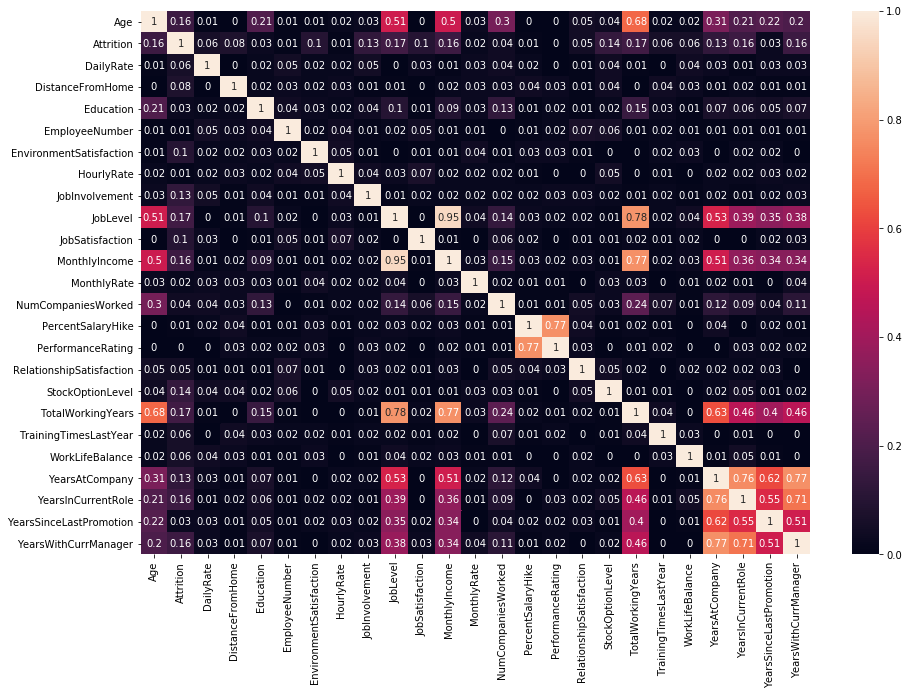

In [195]:
plt.figure(figsize=(15,10))
sns.heatmap(df_num.corr().abs().round(2),annot=True)

In [196]:
df_num=df_num.drop(columns=['PerformanceRating','JobLevel','PerformanceRating','TotalWorkingYears','YearsInCurrentRole','YearsInCurrentRole','YearsWithCurrManager'])

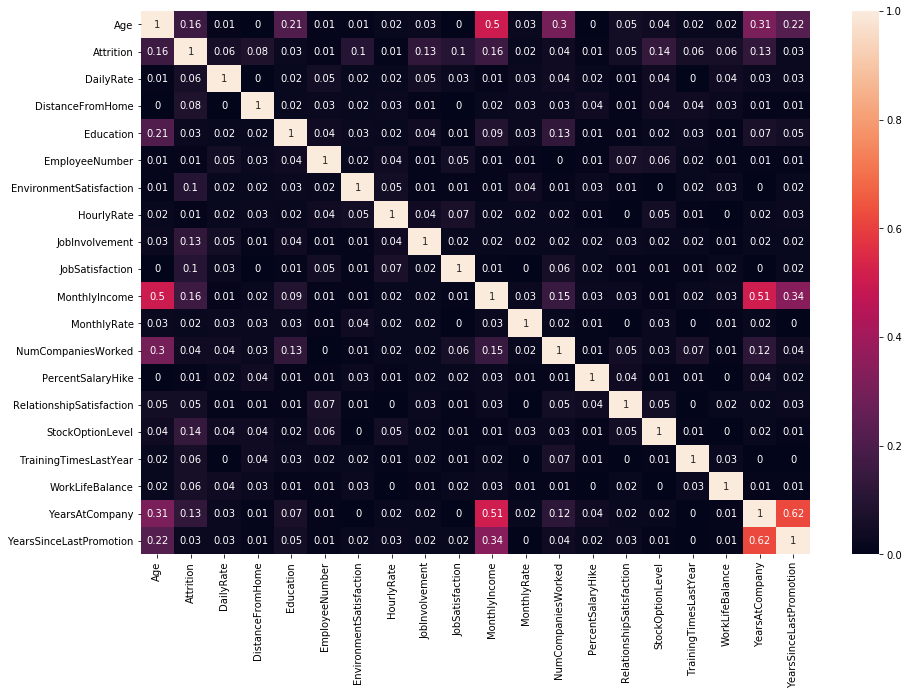

In [197]:
plt.figure(figsize=(15,10))
sns.heatmap(df_num.corr().abs().round(2),annot=True)

In [198]:
# for stats models we do not need to make dummy variables for categorical ones we will make them for sklearn packages.

In [199]:
data=df_num.join(df_object)

In [200]:
#let's see percenatage of customers who didn't subscribe to term deposit,
#and percenatage of customers who subscribed to term deposit
data.Attrition.value_counts()/len(data)*100

0    83.877551
1    16.122449
Name: Attrition, dtype: float64

<h3>83% of employees still work.This means that without any model we will probably clasify a new record (a new employee) as 0, but we want to do better than this very naive classification. </h3>


In [201]:
formula="Attrition~"+"+".join(data.drop(columns=["Attrition"]).columns)

In [202]:
model=Logit.from_formula(formula=formula,data=data).fit()

         Current function value: 0.301998
         Iterations: 35


C:\Users\arman\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [203]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1429
Method:                           MLE   Df Model:                           40
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:                  0.3163
Time:                        23:25:17   Log-Likelihood:                -443.94
converged:                      False   LL-Null:                       -649.29
                                        LLR p-value:                 5.133e-63
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -5.9328     79.122     -0.075      0.940    -161.008     149.143
BusinessTravel[T.Travel_Frequently]        1.8031      0.399      4.514      0.000       1.020       2.586
BusinessTravel[T.Travel_Rarely]            0.9161      0.368      2.488      0.013       0.194       1.638
Department[T.Research_and_Development]     8.3873     79.114      0.106      0.916    -146.673     163.448
Department[T.Sales]                        8.1013     79.115      0.102      0.918    -146.962     163.165
EducationField[T.Life_Sciences]           -0.7070      0.795     -0.890      0.374      -2.264       0.850
EducationField[T.Marketing]               -0.3205      0.842     -0.381      0.703      -1.970       1.330
EducationField[T.Medical]                 -0.7694      0.795     -0.967      0.333      -2.328       0.789
EducationField[T.Other]                   -0.9301      0.857     -1.085      0.278      -2.610       0.750
EducationField[T.Technical_Degree]         0.1181      0.814      0.145      0.885      -1.476       1.713
Gender[T.Male]                             0.3998      0.182      2.202      0.028       0.044       0.756
JobRole[T.Human_Resources]                 9.8444     79.114      0.124      0.901    -145.217     164.906
JobRole[T.Laboratory_Technician]           1.5657      0.468      3.347      0.001       0.649       2.483
JobRole[T.Manager]                         0.7365      0.866      0.851      0.395      -0.960       2.433
JobRole[T.Manufacturing_Director]          0.1171      0.530      0.221      0.825      -0.921       1.155
JobRole[T.Research_Director]              -0.7166      0.940     -0.763      0.446      -2.559       1.125
JobRole[T.Research_Scientist]              0.6773      0.474      1.430      0.153      -0.251       1.605
JobRole[T.Sales_Executive]                 1.3441      1.132      1.187      0.235      -0.874       3.563
JobRole[T.Sales_Representative]            2.4402      1.180      2.068      0.039       0.127       4.753
MaritalStatus[T.Married]                   0.2656      0.263      1.011      0.312      -0.249       0.780
MaritalStatus[T.Single]                    1.0888      0.340      3.205      0.001       0.423       1.755
OverTime[T.Yes]                            1.9234      0.189     10.189      0.000       1.553       2.293
Age                                       -0.0437      0.012     -3.600      0.000      -0.068      -0.020
DailyRate                                 -0.0003      0.000     -1.557      0.119      -0.001    8.74e-05
DistanceFromHome                           0.0433      0.010      4.127      0.000       0.023       0.064
Education                                  0.0003      0.087      0.003      0.997      -0.170       0.170
EmployeeNumber                         -8.891e-05      0.000     -0.603      0.546      -0.000       0.000
EnvironmentSatisfaction        

In [204]:
log_summary=pd.read_html(model.summary().tables[1].as_html(),header=0)[0]
log_summary=log_summary.rename(columns={"Unnamed: 0":"Parameter"})##making summary as dataframe to manipulate easily

In [205]:
## here is significant varialpes that increase posibilities of employee to be in Attrition note for categorical varialbles
# we need to compare  with intercept for example a single epmloyee will more pobably be in attrition list than divorced  
log_summary[["Parameter","coef"]][(log_summary["P>|z|"]<0.01) & (log_summary["coef"]>0)]

,Parameter,coef
1,BusinessTravel[T.Travel_Frequently],1.8031
12,JobRole[T.Laboratory_Technician],1.5657
20,MaritalStatus[T.Single],1.0888
21,OverTime[T.Yes],1.9234
24,DistanceFromHome,0.0433
33,NumCompaniesWorked,0.1722
40,YearsSinceLastPromotion,0.1445


here is significant varialpes that increase posibilities of employee to be in Attrition note
for every one-unit increase in numeric variables, we expect a respectively coef increase in the log-odds of attrition, holding all other independent variables constant.
for categorical varialbleswe need to compare  with intercept for example a single epmloyee will more pobably be in attrition list than divorced 

In [206]:
## and here is significant varialpes that decrease posibilities of employee to be in Attrition
log_summary[["Parameter","coef"]][(log_summary["P>|z|"]<0.01) & (log_summary["coef"]<0)]

,Parameter,coef
22,Age,-0.0437
27,EnvironmentSatisfaction,-0.4035
29,JobInvolvement,-0.5538
30,JobSatisfaction,-0.3781
35,RelationshipSatisfaction,-0.2333
38,WorkLifeBalance,-0.3733


here is significant varialpes that decrease posibilities of employee to be in Attrition note for every one-unit increase in numeric variables, we expect a respectively coef decrease in the log-odds of attrition, holding all other independent variables constant. 

## Logistic regression using sklearn

In [207]:
data=df_num.join(pd.get_dummies(df_object,drop_first=True,prefix=df_object.columns))

In [208]:
Y=data.Attrition
X=data.drop("Attrition",axis=1)

In [209]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,stratify=Y,random_state=42,test_size=0.25)

<h3>This stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.</h3>

In [210]:
model2=LogisticRegression(random_state=42).fit(X_train,Y_train)

In [211]:
#get accuracy score
model2.score(X=X_test,y=Y_test)

0.8858695652173914

In [212]:
##however this model maynot be very stable meaning it may overfit, so we can to train data for 5 different parts of the data
#and then get average of scores.

In [213]:
cv_scores =cross_val_score(LogisticRegression(random_state=42),X,Y,cv=5)
np.mean(cv_scores)

0.8768812394512961

In [214]:
print(classification_report(Y_test,model2.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      0.98      0.94       309
          1       0.79      0.39      0.52        59

avg / total       0.88      0.89      0.87       368



<h4>our model has 0.88 accuracy which is higher than our benchmark so the model is good, but as regarding type 2 error it provide only 0.39 which means that there is only 39 percent chance that we will predict employee churn when it is  actually in Attrition.</h4>

In [215]:
param_dist = {"max_depth": np.arange(3,20),
              "min_samples_leaf": np.arange(50, 100),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier(random_state=42)
# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv =  RandomizedSearchCV(tree,param_dist,cv=5,random_state=42)


# Fit it to the data
tree_cv.fit(X_train,Y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))
print(classification_report(Y_test,tree_cv.predict(X_test)))


Tuned Decision Tree Parameters: {'min_samples_leaf': 71, 'max_depth': 5, 'criterion': 'gini'}
Best score is 0.838475499092559
             precision    recall  f1-score   support

          0       0.85      0.95      0.90       309
          1       0.30      0.12      0.17        59

avg / total       0.76      0.82      0.78       368



In [216]:
tree=DecisionTreeClassifier(min_samples_leaf= 76, max_depth= 8, criterion= 'entropy').fit(X_train,Y_train)
pred=tree.predict(X_test)
print(classification_report(Y_test,pred))

             precision    recall  f1-score   support

          0       0.85      0.95      0.90       309
          1       0.30      0.12      0.17        59

avg / total       0.76      0.82      0.78       368



In [217]:
np.mean(cross_val_score(tree,X,Y,cv=5))#overall average score of the model 0.84

0.8462547492532039

In [218]:
importances=tree.feature_importances_
importances=pd.DataFrame(data=importances, index=X.columns, columns=['importances']).sort_values(by=['importances'],ascending=False)

In [219]:
importances.head(3)## according to decision tree important parameters are following

,importances
YearsAtCompany,0.305732
Age,0.274008
OverTime_Yes,0.192794


In [220]:
#let's visually see new tree
export_graphviz(tree,out_file="tree.dot", class_names=True, feature_names=X.columns, filled=True) 

Overall I would prefer Logistic regression in this case due to the fact that it provides more accurate model than decision tree if we
compare Recall and score results,however, if my target is to predict customer churn netier Logistic method is good because there is only 36 percent chance that it will predict churn equal to 1 when it is acually 1.

## PLS Regression

In [221]:
data=pd.read_excel("education.xlsx",sheet_name="education")

In [222]:
data.head()

,num,sup.help,sup.under,sup.safe,sup.conc,adv.comp,adv.acces,adv.comm,adv.qual,tut.prof,...,sat.glad,sat.expe,sat.over,loy.proud,loy.recom,loy.asha,loy.back,gender,scholarships,job
0,1,7,1,7,4,5,5,6,6,5,...,7,7,7,7,7,1,7,female,yes_scholship,no_job
1,2,7,1,6,4,6,6,5,6,6,...,7,7,7,7,7,1,7,female,yes_scholship,yes_job
2,3,6,1,6,6,6,6,6,6,6,...,7,6,6,7,7,1,7,female,yes_scholship,no_job
3,4,1,7,3,1,1,2,1,1,3,...,1,1,1,1,1,7,1,male,no_scholship,no_job
4,5,6,5,5,7,7,6,7,7,7,...,7,7,7,7,7,1,7,female,yes_scholship,yes_job


In [223]:
#no missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 27 columns):
num             181 non-null int64
sup.help        181 non-null int64
sup.under       181 non-null int64
sup.safe        181 non-null int64
sup.conc        181 non-null int64
adv.comp        181 non-null int64
adv.acces       181 non-null int64
adv.comm        181 non-null int64
adv.qual        181 non-null int64
tut.prof        181 non-null int64
tut.sched       181 non-null int64
tut.stud        181 non-null int64
tut.qual        181 non-null int64
val.devel       181 non-null int64
val.deci        181 non-null int64
val.meet        181 non-null int64
val.info        181 non-null int64
sat.glad        181 non-null int64
sat.expe        181 non-null int64
sat.over        181 non-null int64
loy.proud       181 non-null int64
loy.recom       181 non-null int64
loy.asha        181 non-null int64
loy.back        181 non-null int64
gender          181 non-null object
scholarships    181

In [224]:
data.isnull().any().any() #we should drop missing values, as there are variables that have N/As

False

In [225]:
#separate data into numeric and object subsets
data_numeric = data.select_dtypes(exclude="object")
data_object = data.select_dtypes(include="object")

In [226]:
#check for unique values of categorical variables
print(data_numeric.var().any()==0)
for i in data_object.columns:
    if len(data_object[i].unique())==1:
        print (i)

False


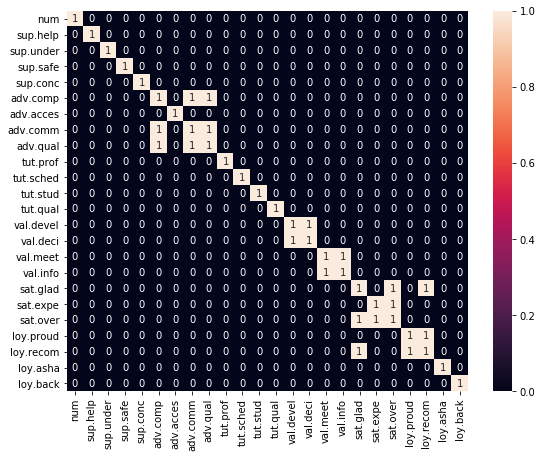

In [227]:
#we can see that there are many correlated variables
plt.figure(figsize=(9, 7)) #make the graph bigger
sns.heatmap(data_numeric.corr().abs().round(2)>0.75, annot=True)
plt.show()

In [228]:
##as wee see our response variables are correlated each other as expected,additionally we have multicolinearity in independent
#variables as wee, so using Partial Least Squared Regression can handle multicolinearitiy,
#PLS maximizes the covariance between the target variables (Y) and
#he predictive variables (X).#
# Basically we want to do linear regression between two matrices

In [229]:
data = data_numeric.join(pd.get_dummies(data_object,prefix=data_object.columns,drop_first=True))

In [230]:
data.columns

Index(['num', 'sup.help', 'sup.under', 'sup.safe', 'sup.conc', 'adv.comp',
       'adv.acces', 'adv.comm', 'adv.qual', 'tut.prof', 'tut.sched',
       'tut.stud', 'tut.qual', 'val.devel', 'val.deci', 'val.meet', 'val.info',
       'sat.glad', 'sat.expe', 'sat.over', 'loy.proud', 'loy.recom',
       'loy.asha', 'loy.back', 'gender_male', 'scholarships_yes_scholship',
       'job_yes_job'],
      dtype='object')

In [231]:
Y=data[['sat.glad', 'sat.expe', 'sat.over']]
X=data.drop(columns=Y.columns)

In [232]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=42,test_size=0.25)

In [233]:
pls2 = PLSRegression(scale=True,n_components=24).fit(X_train, Y_train)
#let's use the model to do prediction for test data
pred=pls2.predict(X_test)
#R-square
pls_r2=pls2.score(X_test,Y_test)
print(pls_r2)

0.37999932123190416


In [234]:
pls2 = PLSRegression(scale=True,n_components=12).fit(X_train, Y_train)
#let's use the model to do prediction for test data
pred=pls2.predict(X_test)
#R-square
pls_r2=pls2.score(X_test,Y_test)
print(pls_r2)

0.3883586364344028


In [235]:
##we will use last model as looking at plt line changes more slightly

In [237]:
#this gives all coefs per all 24 X variables
coef=pd.DataFrame(pls2.coef_)
coef

,0,1,2
0,-0.094864,-0.008203,0.013534
1,-0.083586,-0.042001,-0.083421
2,-0.026604,-0.119769,-0.047688
3,0.038171,0.091967,0.037400
4,0.084963,0.082378,0.007045
5,0.032418,0.021941,0.053936
6,-0.057747,-0.111871,0.078416
7,0.082887,-0.005107,0.194521
8,0.091429,0.212932,0.084640
9,-0.053044,-0.028304,-0.113876


## we want to calculate how much of the variance of all X variables is explained by each latent variable

In [103]:
#first we need to calculate the variance for each latent variable created
var_xcores=np.var(pls2.x_scores_,axis=0)
#second, lets calculate total variance of all X variables
total_var_X=np.sum(np.var(X_train,axis=0))
#calculate the proportioan of total X variance explained by each latent variable
X_Variance=pd.DataFrame((var_xcores/total_var_X).round(5), columns={"X_Variance"}).reset_index()
#let's keep X_variance i=and cummulative X_Variance as dataframe
X_Variance = X_Variance.rename(columns={'index': 'Latent_Factors'})
X_Variance['Cummulative_X_Variance'] = X_Variance['X_Variance'].cumsum().round(5) #calculates cummulative variance
print(X_Variance)

    Latent_Factors  X_Variance  Cummulative_X_Variance
0                0     0.00325                 0.00325
1                1     0.00043                 0.00368
2                2     0.00047                 0.00415
3                3     0.00038                 0.00453
4                4     0.00028                 0.00481
5                5     0.00030                 0.00511
6                6     0.00024                 0.00535
7                7     0.00018                 0.00553
8                8     0.00020                 0.00573
9                9     0.00020                 0.00593
10              10     0.00015                 0.00608
11              11     0.00015                 0.00623
